# Income Support in Newfoundland and Labrador 

This [Jupyter Lab](https://jupyter.org) notebook studies a data set on income support benefits in Newfoundland and Labrador, spanning a period from **1991** to **2021.** The intention is to try and reveal patterns and trends in the use of income support over time within the province. The data set used in this study was made available online by **Open Data Newfoundland and Labrador.**

## Overview

### How did income support recipients in the province vary by age?

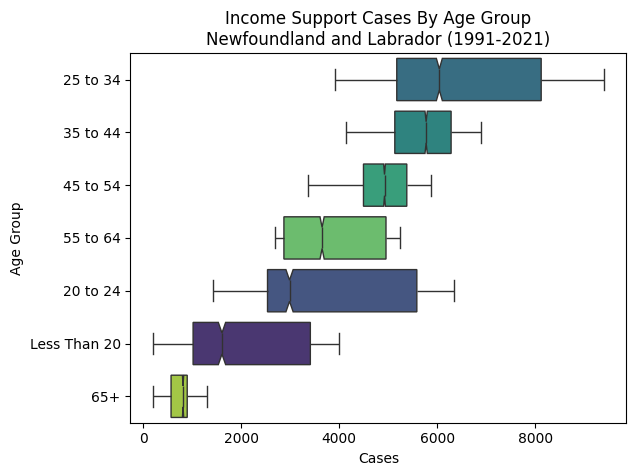

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import zscore
from sklearn.model_selection import KFold


data = pd.read_csv("./Income_Support.csv", encoding='ISO-8859-1', na_values=['..'])

data = data[data['Geography.Type'] == "Community"]

melted_df = pd.melt(data, id_vars=['Year'], value_vars=[
    'Age..Less.than.20',
    'Age..20...24',
    'Age..25...34',
    'Age..35...44',
    'Age..45...54',
    'Age..55...64',
    'Age..65.'
], var_name='age_category', value_name='age_category_value')

melted_df.dropna(subset=['age_category_value'], inplace=True)

melted_df['age_category'] = melted_df['age_category'].replace({
   'Age..Less.than.20': 'Less Than 20', 
   'Age..20...24': '20 to 24',
   'Age..25...34': '25 to 34',
   'Age..35...44': '35 to 44',
   'Age..45...54': '45 to 54',
   'Age..55...64': '55 to 64',
   'Age..65.': '65+'
})

melted_df['sum_value'] = melted_df.groupby(['Year', 'age_category'])['age_category_value'].transform('sum')

data_group = {
    "Less Than 20": melted_df[melted_df['age_category'] == "Less Than 20"]['sum_value'],
    "20 to 24": melted_df[melted_df['age_category'] == "20 to 24"]['sum_value'],
    "25 to 34": melted_df[melted_df['age_category'] == "25 to 34"]['sum_value'],
    "35 to 44": melted_df[melted_df['age_category'] == "35 to 44"]['sum_value'],
    "45 to 54": melted_df[melted_df['age_category'] == "45 to 54"]['sum_value'],
    "55 to 64": melted_df[melted_df['age_category'] == "55 to 64"]['sum_value'],
    "65+": melted_df[melted_df['age_category'] == "65+"]['sum_value']
}

boxplot_data = [data_group[group] for group in ["Less Than 20", "20 to 24", "25 to 34", "35 to 44", "45 to 54", "55 to 64", "65+"]]

plt.title('Income Support Cases By Age Group\nNewfoundland and Labrador (1991-2021)')
plt.xlabel('Cases')
plt.ylabel('Age Group')

# Sort the box plot in descending order by the median value of each age category.
medians = melted_df.groupby('age_category')['sum_value'].median().sort_values(ascending=True)
ordered_categories = medians.index
sns.boxplot(x="sum_value",y="age_category",data=melted_df,order=medians.index,notch=True,palette="viridis",hue="age_category")
plt.gca().invert_yaxis()


The **25-34** age group had the highest average number of income support cases in the province, followed by groups **35-44** and **45-54.** This is significant; the authors of the data set indicate that ages **25-54** may be considered the "prime" labour force age range, yet we can see that the majority of income support cases fall precisely within this range. The group is **positively** skewed, with a median closer to the lower quartile and a slightly longer right whisker. This may indicate that, while income support is common at lower levels in the 25-34 age range, there are exceptional circumstances, or **outliers** that affect the distribution of cases in that age group. 

The **65+** age range accounted for the least overall cases of income support. In this case, the distribution of cases is **negatively** skewed. There are a number of reasons why this may be the case:

- There may be income support programs for seniors in the province that target a consistent and higher level of support for the majority of the population. However, some individuals may receive low support due to special circumstances, such as additional pensions or alternate sources of income.
- Outliers on the lower end could represent individuals with unique financial situations.
- As seniors typically receive stable government pensions or support, this could result in the clustering at the higher end of income support cases.

### Which communities had the highest average numbers of income support cases?

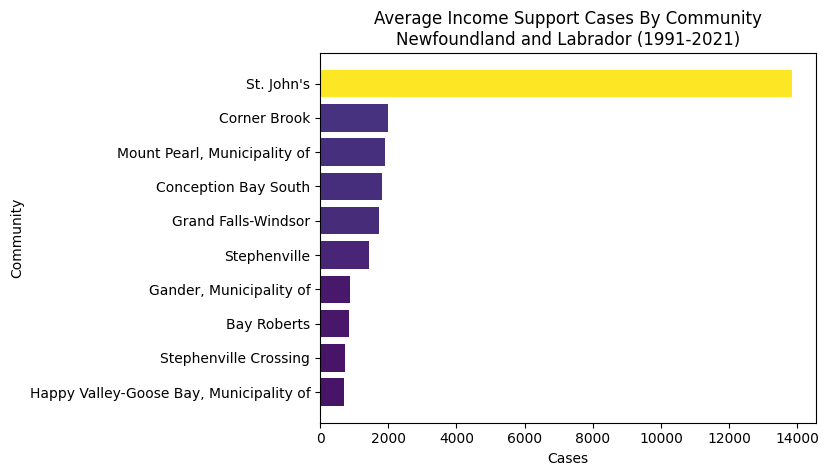

In [108]:
df = data.copy()
df = df.sort_values(by='Year', ascending=False)
df.dropna(subset=['Individuals'],inplace=True)
df['mean_individuals'] = df.groupby('Geography')['Individuals'].transform('mean')
df = df.sort_values(by='mean_individuals', ascending=False)
df.drop_duplicates(subset=['Geography'], inplace=True)
df_top10 = df.head(10)
norm = plt.Normalize(min(df['mean_individuals']), max(df['mean_individuals']))
colors = plt.cm.viridis(norm(df['mean_individuals']))
plt.barh(df_top10['Geography'],df_top10['mean_individuals'],color=colors)
plt.title("Average Income Support Cases By Community\nNewfoundland and Labrador (1991-2021)")
plt.xlabel("Cases")
plt.ylabel("Community")
plt.gca().invert_yaxis()

**St. John's** had the highest average number of individuals on income support by a wide margin. However, one must take population into consideration. **St. John's** is the capital city of the province and its most populated, with over **200,000** people (a significant portion of the entire province's population) residing there.

### Which communities had the highest average percentage of income support cases?

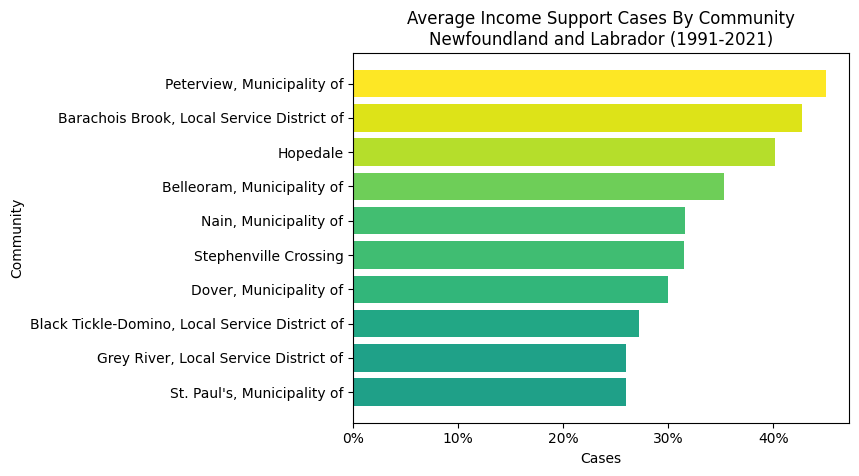

In [109]:
df = data.copy()
df.dropna(subset=['Income.Support.Assistance.Incidence'],inplace=True)
df['mean_incidence'] = df.groupby('Geography')['Income.Support.Assistance.Incidence'].transform('mean')
df = df.sort_values(by='mean_incidence', ascending=False)
df.drop_duplicates(subset=['Geography'],inplace=True)
df_top10 = df.head(10)
norm = plt.Normalize(min(df['mean_incidence']), max(df['mean_incidence']))
colors = plt.cm.viridis(norm(df['mean_incidence']))
plt.barh(df_top10['Geography'],df_top10['mean_incidence'],color=colors)
plt.title("Average Income Support Cases By Community\nNewfoundland and Labrador (1991-2021)")
plt.xlabel("Cases")
plt.ylabel("Community")
plt.gca().invert_yaxis()
# Format the y-axis to show percentages.
def to_percent(y, _):
    return f"{y * 100:.0f}%"  # Convert decimal to percentage.

plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))

The **Municipality of Peterview** had the highest average incidence of income support in the province, with an average of over **40%** of the population of the community availing of income support benefits.

## Education

### What were the levels of education among income support cases?

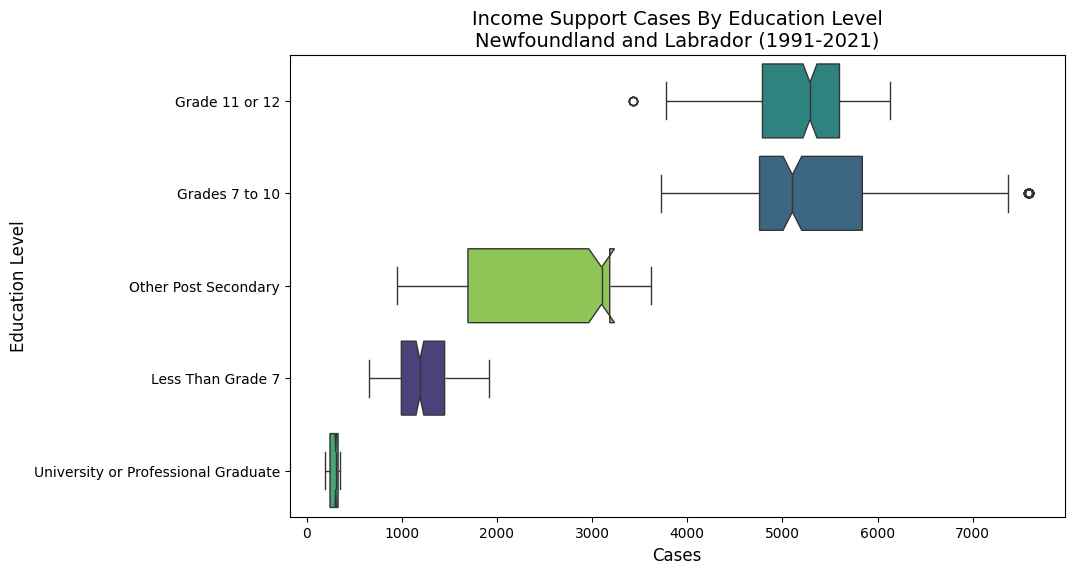

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = data.copy()

df = df.dropna(subset=[
    'Education..Less.than.grade.7',
    'Education..Grades.7.to.10',
    'Education..Grade.11.or.12',
    'Education..University.or.professional.graduate',
    'Education..Other.post.secondary'
])

melted_df = pd.melt(
    df, 
    id_vars=['Year'], 
    value_vars=[
        'Education..Less.than.grade.7',
        'Education..Grades.7.to.10',
        'Education..Grade.11.or.12',
        'Education..University.or.professional.graduate',
        'Education..Other.post.secondary',
    ], 
    var_name='education_category', 
    value_name='education_category_value'
)

melted_df['education_category_value_sum'] = melted_df.groupby(
    ['Year', 'education_category']
)['education_category_value'].transform('sum')

melted_df['education_category'] = melted_df['education_category'].replace({
    'Education..Less.than.grade.7': 'Less Than Grade 7',
    'Education..Grades.7.to.10': 'Grades 7 to 10',
    'Education..Grade.11.or.12': 'Grade 11 or 12',
    'Education..University.or.professional.graduate': 'University or Professional Graduate',
    'Education..Other.post.secondary': 'Other Post Secondary',
})

medians = melted_df.groupby('education_category')['education_category_value_sum'].median().sort_values(ascending=False)
ordered_categories = medians.index

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="education_category_value_sum", 
    y="education_category", 
    data=melted_df, 
    order=ordered_categories, 
    notch=True, 
    palette="viridis",
    hue="education_category"
)

plt.title('Income Support Cases By Education Level\nNewfoundland and Labrador (1991-2021)', fontsize=14)
plt.xlabel('Cases', fontsize=12)
plt.ylabel('Education Level', fontsize=12)

plt.show()

Grades **7-10** and **grade 11 or 12** has the largest spread, indicating a high amount of variability in the number of income support cases. **Grade 11 or 12** has the highest median number of cases of any group. Both groups demonstrate long whiskers and outliers on the high end (this is particularly so for grades 7 to 10). This could be due to some of the individuals in that group requiring much more support than the majority. The **less than grade 7** group's spread is smaller, indicating fewer income support cases in general. **University or professional graduates** had the smallest spread and the lowest median number of cases of an grooup; in short, individuals with higher education levels, particularly university degrees, are less likely to require income support.

Education level appears to be inversely correlated with income support cases; the higher the education level, the fewer the cases in the respective group. This highlights the importance of one pursuing a post secondary education; it makes one far less likely to require financial support in the future of any kind, including income support.

### How does poor education and unemployment affect the total number of individuals on income support?

First, we should determine whether or not any correlation exists between the variables in question. We can do so by examining a correlation matrix.

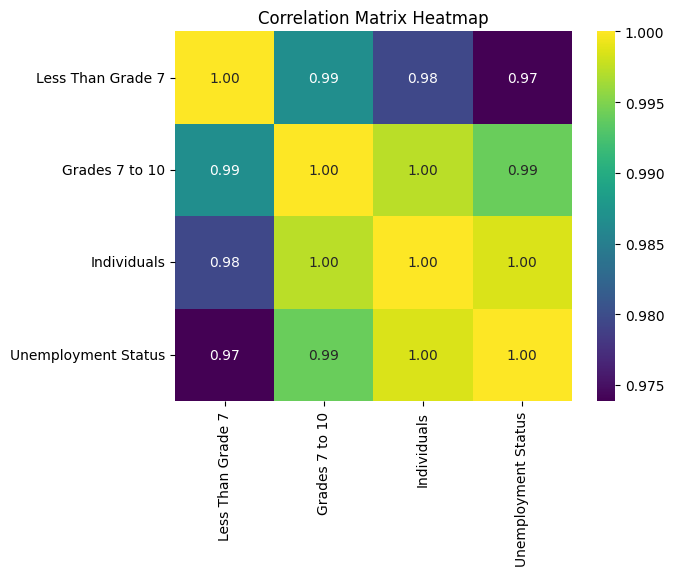

In [111]:
df = data.copy()
df = df.filter(items=['Education..Less.than.grade.7','Education..Grades.7.to.10','Individuals','Employment.Status..Unemployed'])
df.rename(columns={
    'Education..Less.than.grade.7': 'Less Than Grade 7',
    'Education..Grades.7.to.10':'Grades 7 to 10',
    'Employment.Status..Unemployed':'Unemployment Status'
}, inplace=True)

correlation_matrix = df.corr()

# Plot the correlation matrix as a heat map.
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


The correlation matrix reveals a high, **positive** linear correlation between the different variables under consideration. We can attempt to model this relationship with a **linear regression.**

#### Linear Regression

In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7','Education..Grades.7.to.10','Employment.Status..Unemployed'],inplace=True)
# Split data into features (X) and target (Y)
X = df[['Education..Less.than.grade.7','Education..Grades.7.to.10','Employment.Status..Unemployed']]  # Feature (independent variable)
y = df['Individuals']    # Target (dependent variable)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Coefficients and intercept
print("Coefficient (Slope):", model.coef_[0])
print("Intercept:", model.intercept_)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Coefficient (Slope): 1.9869604187595549
Intercept: -1.9238603440516044
Mean Squared Error: 908.9629176156213
R-squared: 0.9988912693520006


The model is an excellent fit for the training data set, though the high MSE value may indicate some variance in the data that is not captured perfectly. We can proceed with analyzing its effectiveness on the test data set.

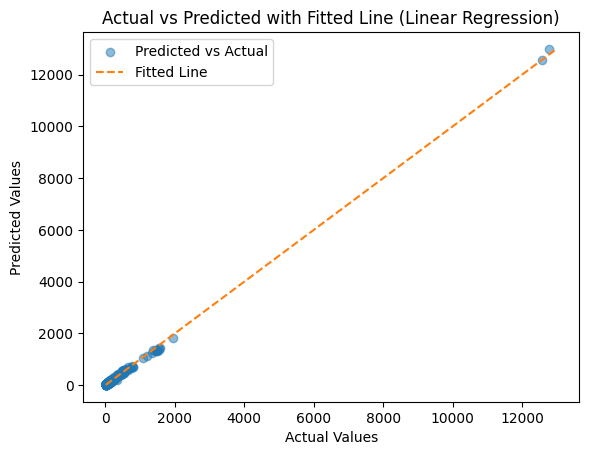

In [113]:
# Scatter plot of actual vs predicted
plt.scatter(y_test, y_pred, color='tab:blue', label='Predicted vs Actual',alpha=0.5)

# Fitted line
line_start = min(y_test.min(), y_pred.min())
line_end = max(y_test.max(), y_pred.max())
plt.plot([line_start, line_end], [line_start, line_end], color='tab:orange', linestyle='--', label='Fitted Line')

# Labels and legend
plt.title("Actual vs Predicted with Fitted Line (Linear Regression)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)

plt.show()

The model appears to describe and predict the data well, but we can further analyze its efficacy by studying a plot of the residuals.

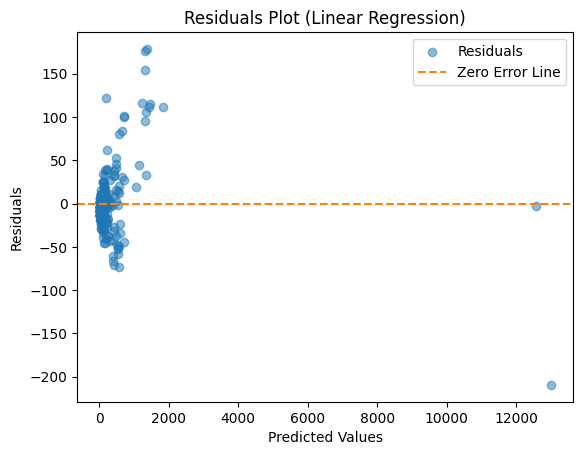

In [114]:
residuals = y_test - y_pred

# Display a scatter plot of the residuals.
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5, label='Residuals')
plt.axhline(y=0, color='tab:orange', linestyle='--', label='Zero Error Line')

plt.title("Residuals Plot (Linear Regression)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(False)

plt.show()

There are patterns in the residuals plot. The residuals appear to be concentrated aroud lower predicted values, with very few points at the higher end. The model may be underestimating or overestimating for larger predicted values. The latter points (around 12,000) **could** be outliers, or data points where the model had trouble making accurate predictions.

There is evidence of **heteroscedasticity.** The spread of the residuals increases as the predicted values grow. This could suggest that the model's assumptions about the data are incorrect. Education levels and unemployment status are **certainly** correlated with a lower incidence of income support cases, but the model of the relationship between these variables may, in this case, need adjustment. One potential adjustment would be to log transform the dependent variable before splitting the training and test data sets.

In [115]:
# Prepare data
df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)

# Split data into features (X) and target (Y)
X = df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]  # Features
y = np.log(df['Individuals'])  # Log-transform the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_log = model.predict(X_test)  # Predictions in log scale
y_pred = np.exp(y_pred_log)  # Convert predictions back to original scale

# Coefficients and intercept
print("Coefficient (Slope):", model.coef_)
print("Intercept (Log Scale):", model.intercept_)

# Evaluate the model
mse = mean_squared_error(np.exp(y_test), y_pred)  # Compare in the original scale
r2 = r2_score(np.exp(y_test), y_pred)
print("Mean Squared Error (Original Scale):", mse)
print("R-squared (Original Scale):", r2)

# Optionally: Evaluate in the log scale
mse_log = mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
print("Mean Squared Error (Log Scale):", mse_log)
print("R-squared (Log Scale):", r2_log)


Coefficient (Slope): [ 0.01902149 -0.00636809  0.00188393]
Intercept (Log Scale): 4.082713164255618
Mean Squared Error (Original Scale): 296359514.9303815
R-squared (Original Scale): -360.4920594247232
Mean Squared Error (Log Scale): 0.9511132162823346
R-squared (Log Scale): 0.28085429469228296


It does not appear that a log transformation of the dependent variable improves the efficacy of the model in this case. We can examine the residuals plot to be certain.

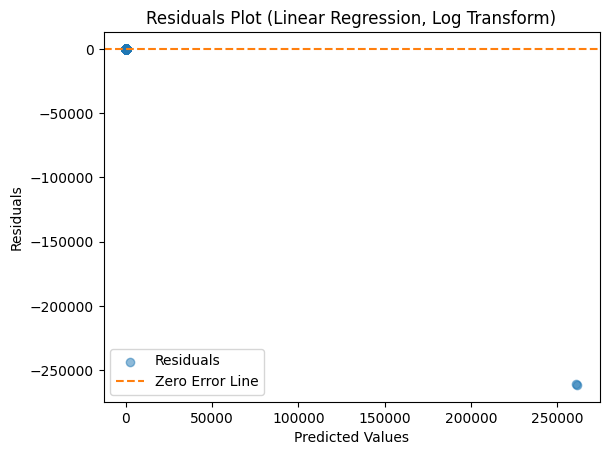

In [116]:
residuals = y_test - y_pred

# Display a scatter plot of the residuals.
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5, label='Residuals')
plt.axhline(y=0, color='tab:orange', linestyle='--', label='Zero Error Line')

plt.title("Residuals Plot (Linear Regression, Log Transform)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(False)

plt.show()

There is a very obvious and large range to the residuals in this example. A few residual points deviate significantly from the zero line, indicating poor model performance or potential outliers. In addition, the spread of the residuals is not even. For smaller predicted values, the residuals are tightly clustered near the zero line, while for larger predicted values, they increase significantly. This could indicate **heteroscedasticity.** In either case, a simple log transformation is not sufficient to resolve the issues with this particular model.

We could, instead of a simple linear regression, attempt to apply a polynomial regression to the same data set.

#### Polynomial Regression

In [127]:
df = data.copy()
df.dropna(subset=['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)

X = df[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]  # Feature set.
y = np.sqrt(df['Individuals'])  # Perform a square root transformation on the target variable.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a polynomial regression model of degree 2. This value can be adjusted.
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the model.
model.fit(X_train, y_train)

# Generate some predictions.
y_pred = model.predict(X_test)

# Convert predictions back to the original scale.
y_pred_original = np.square(y_pred)  # Reverse square root transformation.

# Coefficients and intercept from the linear regression step in the pipeline.
coefficients = model.named_steps['linearregression'].coef_
intercept = model.named_steps['linearregression'].intercept_
print("Coefficients (Polynomial Terms):", coefficients)
print("Intercept:", intercept)

# Evaluate the model in the original scale.
mse = mean_squared_error(np.square(y_test), y_pred_original)  # Compare on the original scale
r2 = r2_score(np.square(y_test), y_pred_original)
print("Mean Squared Error (Original Scale):", mse)
print("R-squared (Original Scale):", r2)

# Perform cross-validation
cv_scores_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # MSE
cv_scores_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')  # R-squared

# Print cross-validation results
print("Cross-Validation Mean Squared Error (MSE):", np.mean(cv_scores_mse))
print("Cross-Validation R-squared (R2):", np.mean(cv_scores_r2))


Coefficients (Polynomial Terms): [ 0.00000000e+00  2.97029529e-03  9.08282819e-02  9.85061599e-03
  2.70748811e-03 -2.72625282e-03  6.00217295e-04  6.59908835e-04
 -2.90876900e-04  2.86432582e-05]
Intercept: 5.793345888593441
Mean Squared Error (Original Scale): 15007.87900153545
R-squared (Original Scale): 0.981693757701228
Cross-Validation Mean Squared Error (MSE): 7.856022154936523
Cross-Validation R-squared (R2): 0.9401788984426662


The cross-validation MSE and $R^2$ in this instance both indicate that the model is a good fit for the data. We should, as always, examine a residuals plot to determine the model's efficacy. We can plot the fitted curve against the data set as follows.

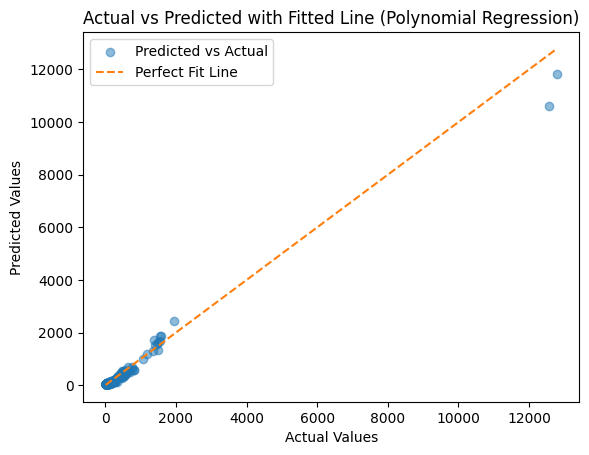

In [128]:
# Fitted curve plot
plt.scatter(np.square(y_test), y_pred_original, alpha=0.5, label="Predicted vs Actual",color="tab:blue")
plt.plot([min(np.square(y_test)), max(np.square(y_test))], 
         [min(np.square(y_test)), max(np.square(y_test))], 
         color="tab:orange", linestyle="--", label="Perfect Fit Line")
plt.title("Actual vs Predicted with Fitted Line (Polynomial Regression)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)
plt.show()

Polynomial regression **appears** to provide a reasonable fit for the data. We should examine this more closely by studying the residuals plot.

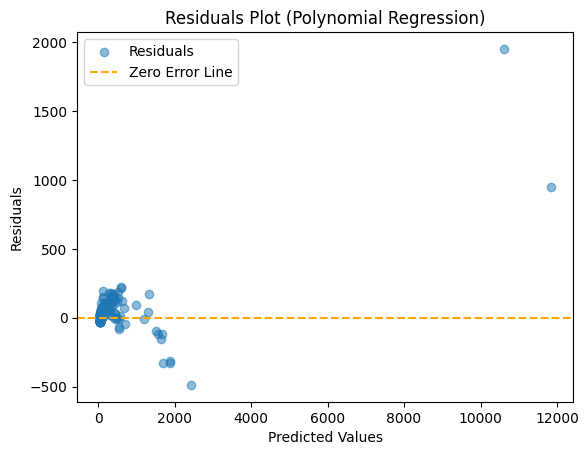

In [118]:
import matplotlib.pyplot as plt

residuals = np.square(y_test) - y_pred_original
plt.scatter(y_pred_original, residuals, alpha=0.5, label="Residuals")
plt.axhline(0, color='orange', linestyle='--', label="Zero Error Line")
plt.title("Residuals Plot (Polynomial Regression)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(False)
plt.show()

Polynomial regression is an **improvement** upon our original model. In comparison to the residuals plot of the linear regression model, this plot shows a more evenly distributed set of residuals around the zero-error line, particularly for lower predicted values. This suggests that the polynomial regression model is capturing the non-linear patterns in the data better than a simple linear regression. There is still a clustering of residuals near the lower end of the scale, however, which could indicate that additional transformations or feature engineering might improve upon the situation. There are also some obvious outliers in this data set; the model may perform better if those outliers were removed entirely or treated in some other way.

What if the outlier values in the number of individuals are removed before analysis? We will also "tune" the model by choosing a higher degree of polynomial.

#### Polynomial Regression (Outliers Removed, Degree = 3)

In [119]:
# Step 1: Compute Z-score for the Individuals column and remove any identified outliers.
df = data.copy()
df.dropna(subset=['Individuals', 'Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed'], inplace=True)
df['Z_Score'] = zscore(df['Individuals'])
df_cleaned = df[np.abs(df['Z_Score']) <= 3].drop(columns=['Z_Score'])

# Step 2: Define the feature set and the target variable.
X = df_cleaned[['Education..Less.than.grade.7', 'Education..Grades.7.to.10', 'Employment.Status..Unemployed']]
y = df_cleaned['Individuals']

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation.
cv_mse = -cross_val_score(model, X_poly, y, cv=kf, scoring='neg_mean_squared_error')  # Use neg_mean_squared_error for scoring.
cv_r2 = cross_val_score(model, X_poly, y, cv=kf, scoring='r2')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate some summary statistics on the model's performance.
print("Mean Squared Error (MSE) on Test Data:", mse)
print("R-squared on Test Data:", r2)
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

print("Cross-Validation Mean Squared Error (MSE):", cv_mse.mean())
print("Cross-Validation R-squared:", cv_r2.mean())


Mean Squared Error (MSE) on Test Data: 327.49106718078684
R-squared on Test Data: 0.9945071478250971
Model Coefficients: [ 0.00000000e+00 -3.39627419e-01  7.27254199e-01  1.32284963e+00
 -1.36260247e-02  6.61477800e-02 -2.17206609e-02 -2.08460682e-02
  1.34875536e-02 -1.97290271e-03  1.95258204e-03 -5.10993493e-03
  1.29269834e-03  2.99101654e-03 -1.35454480e-03  1.52023405e-04
 -6.21757430e-04  4.50589372e-04 -1.15782585e-04  1.05213167e-05]
Model Intercept: 2.3507815909759415
Cross-Validation Mean Squared Error (MSE): 381.1521336241237
Cross-Validation R-squared: 0.9957852453642072


With the outliers removed, the polynomial regression model appears to perform exceptionally well. Let us examine a plot of the residuals.

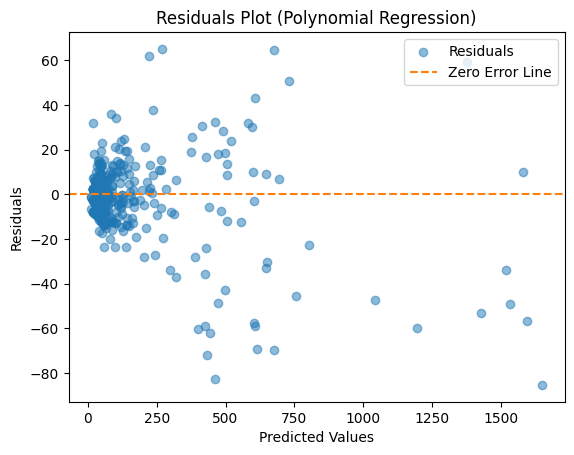

In [120]:
# Step 11: Residuals Calculation
residuals = y_test - y_pred

# Step 12: Plot Residuals
plt.scatter(y_pred, residuals, color='tab:blue', alpha=0.5, label='Residuals')
plt.axhline(y=0, color='tab:orange', linestyle='--', label='Zero Error Line')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot (Polynomial Regression)")
plt.legend()
plt.show()

With the outlier values removed, we can see that the residuals in the above plot are much more closely centered about the zero line, indicating that the model is generally unbiased in these conditions. There is a clear clustering of predicted values around the lower end of the scale, which may suggest that the model actually performs better for lower predictions. The spread of the residuals still indicates **heteroscedasticity.** The outliers have been removed in advance, so the points deviating from the zero line in this case likely indicate places where the model is having trouble making accurate predictions.
Nonetheless, this residuals plot, in comparison to the last, displays a more consistent spread with fewer outliers and improved uniformity of variance, generally indicating a better fit to the data. Clearly, addressing outliers in this case has improved upon the model's performance.

Let us now view a fitted curve of the model's predicted values to the actual values of cases with a less than grade 7 level education.

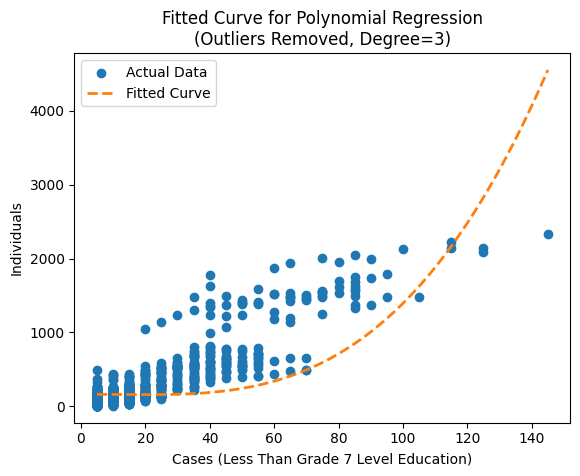

In [121]:
# Fix two features at their mean values and vary one feature to plot the fitted curve.
mean_values = df_cleaned[['Education..Grades.7.to.10', 'Employment.Status..Unemployed']].mean()
x_range = np.linspace(X['Education..Less.than.grade.7'].min(), X['Education..Less.than.grade.7'].max(), 100)

# Create a data set where two features are fixed at their mean, while one feature varies.
fixed_data = pd.DataFrame({
    'Education..Less.than.grade.7': x_range,
    'Education..Grades.7.to.10': mean_values['Education..Grades.7.to.10'],
    'Employment.Status..Unemployed': mean_values['Employment.Status..Unemployed']
})

# Apply PolynomialFeatures to the fixed dataset.
fixed_poly = poly.transform(fixed_data)

# Predict using the trained model.
fitted_values = model.predict(fixed_poly)

# Plotting
plt.scatter(X['Education..Less.than.grade.7'], y, color='tab:blue', label='Actual Data')
plt.plot(x_range, fitted_values, color='tab:orange', label='Fitted Curve', linewidth=2, linestyle="--")
plt.xlabel('Cases (Less Than Grade 7 Level Education)')
plt.ylabel('Individuals')
plt.title('Fitted Curve for Polynomial Regression\n(Outliers Removed, Degree=3)')
plt.legend()
plt.show()

The model captures the trend quite well; as the number of cases with a poor level of education increases, the number of individuals on income support also increases. However, the fitted curve is less than ideal. We might instead choose another model entirely, to see if it provides a better fit for the data.

#### Ridge Regression

With **polynomial regression,** the relationship between the independent variable and the dependent variable is modeled as an $n$-degree polynomial. It is an extension of linear regression that attempts to fit a non-linear curve to the data. In contrast, **ridge regression** is a type of linear regression with [regularization,](https://en.wikipedia.org/wiki/Regularization_(mathematics)) a process that "converts the answer of a problem to a simpler one," according to Wikipedia. Whereas polynomial regression handles non-linear relationships on its own, ridge regression requires adjustment and carefully engineered features in order to deal with non-linearity in the data. Polynomial regression is prone to overfitting; in contrast, ridge regression provides penalties for large coefficients that prevent such overfitting. The general purpose behind both approaches differs as well; polynomial regression, as stated previously, is used to model non-linear relationships in the data. The key point to ridge regression is regularization; ridge regression is used to regularize linear models that may suffer from overfitting.

How does all of this apply to our data set? We can evaluate the performance of the model in a similar fashion to the others we have studied.

In [122]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import numpy as np

# Scale the polynomial features. If this is not performed first, a warning will be generated.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit and train the model.
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# Make some predictions and evaluate the summary statistics.
y_pred_ridge = ridge_model.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression - MSE:", mse_ridge)
print("Ridge Regression - R-squared:", r2_ridge)
# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate MSE using cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_mse_scores = cross_val_score(ridge_model, X_scaled, y, cv=kf, scoring=mse_scorer)
mean_cv_mse = -np.mean(cv_mse_scores)  # Negate to get positive MSE

# Evaluate R-squared using cross-validation
cv_r2_scores = cross_val_score(ridge_model, X_scaled, y, cv=kf, scoring='r2')
mean_cv_r2 = np.mean(cv_r2_scores)

print("Cross-Validation Mean MSE:", mean_cv_mse)
print("Cross-Validation Mean R-squared:", mean_cv_r2)

# Combine training and test data for visualization
X_combined_scaled = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))
y_pred_combined = ridge_model.predict(X_combined_scaled)

# Sort predictions for a smoother curve
sorted_indices = np.argsort(y_combined)
y_combined_sorted = y_combined[sorted_indices]
y_pred_combined_sorted = y_pred_combined[sorted_indices]

Ridge Regression - MSE: 340.16324767575026
Ridge Regression - R-squared: 0.9942946033584901
Cross-Validation Mean MSE: 510.2209014157528
Cross-Validation Mean R-squared: 0.9943450741010886


The MSE and $R^2$ values in this case indicate that the model is a good fit for the data. The cross-validation mean MSE is slightly higher in this case, which could indicate that the model might perform worse on unseen data. The $R^2$ value remains consistent, however, demonstrating that the model explains nearly all variance across the different folds. We can now generate a plot of the curve fitted to our data.

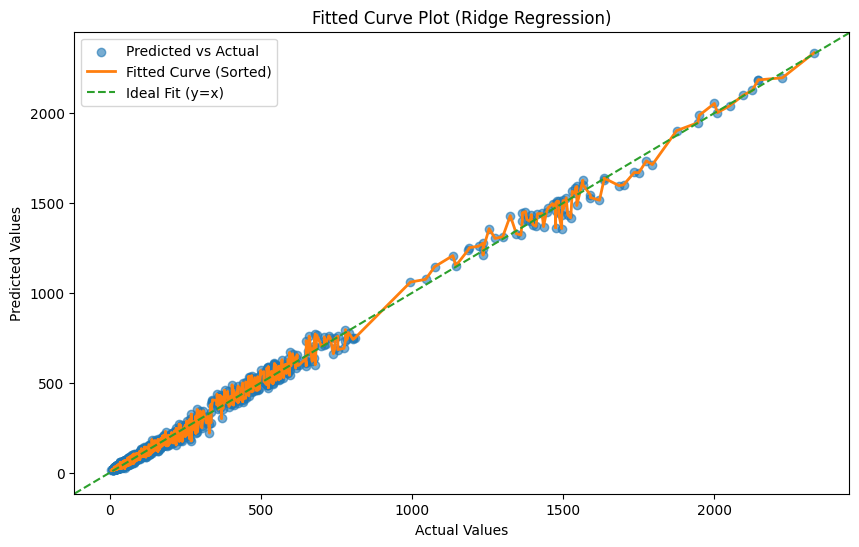

In [123]:
# Plot the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_pred_combined, alpha=0.6, label="Predicted vs Actual", color="tab:blue")
plt.plot(y_combined_sorted, y_pred_combined_sorted, color="tab:orange", label="Fitted Curve (Sorted)", linewidth=2)
plt.axline((0, 0), slope=1, color='tab:green', linestyle='--', label="Ideal Fit (y=x)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Fitted Curve Plot (Ridge Regression)")
plt.legend()
plt.show()

The fitted curve plot reveals that the **ridge regression** model provides a very good fit to our data set. In evaluating the performance of the model, however, the residuals plot should always be analyzed at the very least.

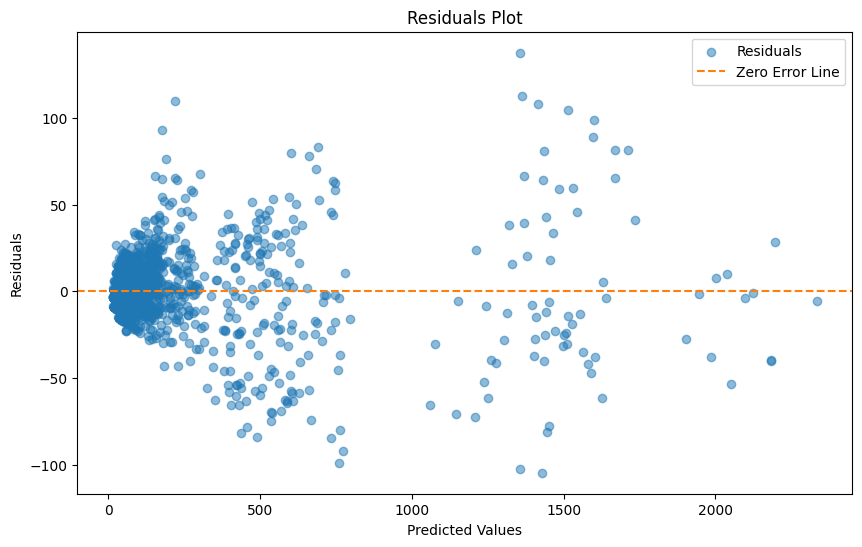

In [124]:
# Residuals Plot
residuals = y_combined - y_pred_combined
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_combined, residuals, alpha=0.5, color="tab:blue", label="Residuals")
plt.axhline(0, color="tab:orange", linestyle="--", label="Zero Error Line")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.show()

# Cross-Validation
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Assuming X is the full dataset
if isinstance(y, pd.Series):
    y = y.values  # Convert y to a NumPy array if it's a Pandas Series

# Set up Ridge Regression
ridge_model = Ridge(alpha=1.0)


The residuals in this case are closely centered around the zero line. This is a good indication that the model is not overpredicting or underpredicting in a systematic way. In terms of the spread of the residuals, for lower predicted values the residuals are tightly clustered with a small spread. For higher predicted values the spread of the residuals is more broad, suggesting that at larger scales, the model might have higher variance. 

When it comes to modelling the relationship between poor eduaction, unemployment and the total number of income support cases in Newfoundland and Labrador, **ridge regression** provides the best results of any method or model attempted. It is clear, however, that in evaluating the performance of a model, one must always be more rigorous than simply plotting a fitted curve and observing the results. Through the use of ridge regression as a model, we can definitively state that there is a **positive** relationship between poor education, unemployment and the number of income support cases in the province. As the number of poorly educated and unemployed individuals increase, the number of total income support cases also increases. Further, the model could be used to predict the future number of income support cases which meet those terms.             

## Families

### How large were the families of income support cases on average?

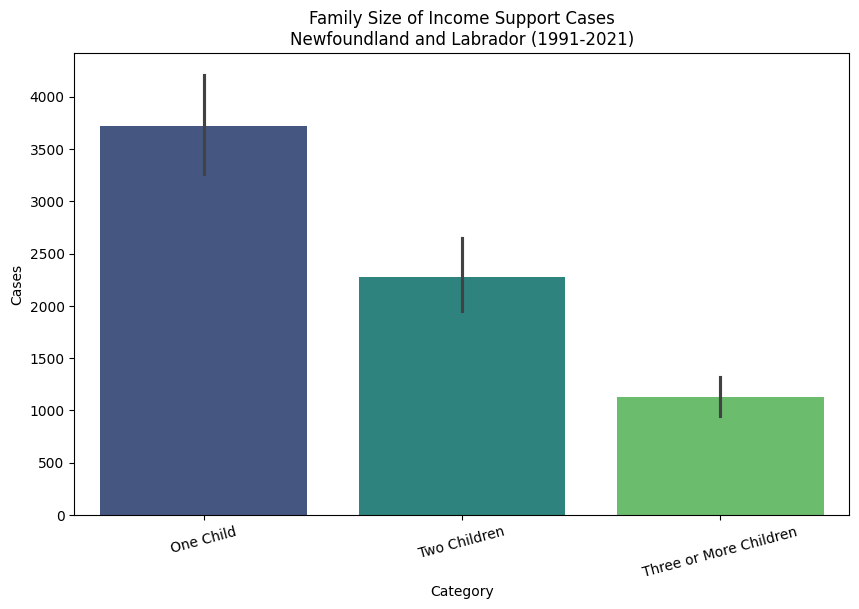

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = data.copy()
df.dropna(subset=['Children..One.child', 'Children..Two.children', 'Children..Three.or.more.children'], inplace=True)

melted_df = df.melt(
    id_vars=['Year'],
    value_vars=['Children..One.child', 'Children..Two.children', 'Children..Three.or.more.children'],
    var_name='children_category',
    value_name='children_category_values'
)

melted_df['children_category'] = melted_df['children_category'].replace({
   'Children..One.child': 'One Child', 
   'Children..Two.children': 'Two Children',
   'Children..Three.or.more.children': 'Three or More Children',
})

# Calculate the total sum for each category across all years.
category_order = (
    melted_df.groupby('children_category')['children_category_values']
    .sum()
    .sort_values(ascending=False)
    .index
)

# Reorder the categories based on the sorted sums.
summed_df = melted_df.groupby(['children_category', 'Year'])['children_category_values'].sum().reset_index()
summed_df['children_category'] = pd.Categorical(
    summed_df['children_category'],
    categories=category_order,
    ordered=True
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=summed_df,
    x='children_category',
    y='children_category_values',
    palette='viridis',
    hue="children_category",
    order=category_order  # This line ensures the bars are sorted from greatest to least.
)
plt.title('Family Size of Income Support Cases\nNewfoundland and Labrador (1991-2021)')
plt.xlabel('Category')
plt.ylabel('Cases')
plt.xticks(rotation=15)
plt.show()


The majority of families on income support have only **one** child.

### How much in benefits were paid out to families on average?

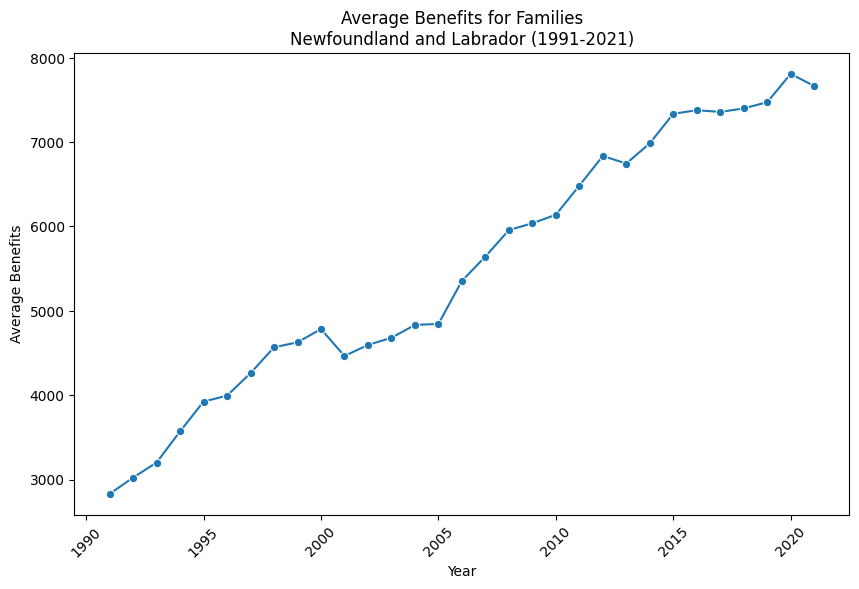

In [126]:
df = data.copy()
df.dropna(subset=[
    "Total.Families..Average.benefits"
],inplace=True)

df = df.groupby('Year')['Total.Families..Average.benefits'].mean().sort_values(ascending=False).reset_index()
# Create a Seaborn line plot.
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Year',
    y='Total.Families..Average.benefits',
    marker='o',
    color='tab:blue'
)
plt.title('Average Benefits for Families\nNewfoundland and Labrador (1991-2021)')
plt.xlabel('Year')
plt.ylabel('Average Benefits')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

The amount paid out to families in income support benefits has **increased** with time, to keep pace with economic factors such as inflation and rising costs of living. A family on income support in 1991 received an average of less than $2,000 in benefits per year. A family in 2021 received more than **double** that amount. The steady growth in the amount of average benefits paid out indicates a positive trend in the financial support provided for families.

From around 2005 onward, there is a more steady progression in the increase in average benefits. In later years this growth slows down slightly, so that by 2020 they have either reached a peak, or the rate of increase stabilized. The overall trend represents long-term commitment by government and policy makers to improve the condition of families on income support across the province.

## Conclusion

A number of interesting facts have been revealed by this study. In terms of age groups, the age range of **25-54** had the most number of income support cases in the province. However, the authors of the data set note in the accompanying metadata that this age range is considered the "prime" labour force age range. Nonetheless, the majority of income support cases fall within this range. 

Income support recipients were more likely to be poorly educated and unemployed. This relationship was studied with the successful use of a **ridge regression** model, which indicated that as the number of poorly educated, unemployed individuals increase, the total number of income support cases (naturally) increases as well.

Families on income support tended to have one child on average. The amount in benefits paid out to families in the province has increased dramatically over the years, to the point that a family in 2021 received more than **double** the average benefits of a family in 1991. That amount has reached something of a plateau in 2020, which may be of concern. The rising costs of living are a huge issue in Newfoundland and Labrador, so much so that the government has dedicated a huge amount of effort into [addressing the issue.](https://www.gov.nl.ca/fin/cost-of-living-measures/) Even so, the data indicates that there has been a multi-year, sustained effort into providing support for families in the province, as well as to ensure that support matches well with increases in the costs of living.

## Acknowledgements

This notebook was authored with assistance from [ChatGPT](https://chatgpt.com), which assisted in fixing a number of persistent bugs and issues in the code for the notebook, as well as providing a valuable resource of facts and knowledge on the subjects of linear and polynomial regression. Math and statistics are not my strong point, so I rely a great deal on research papers, videos and websites which explain the details in terms that anyone can understand. My thanks to **OpenAI** for providing such an amazing tool to the public, free of charge.